In [ ]:
import os
import json
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision.transforms import functional as F
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import torch.optim as optim

from google.colab import drive
drive.mount('/content/drive')

# Define the custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_dir, annotation_file):
        self.image_dir = image_dir
        self.annotation_file = annotation_file
        self.images = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])

        # Load annotations
        with open(annotation_file, 'r') as f:
            self.annotations_data = json.load(f)
            self.annotations = self.annotations_data.get('annotations', [])
            self.categories = {cat['id']: cat['name'] for cat in self.annotations_data.get('categories', [])}
            self.image_id_map = {img['id']: img['file_name'] for img in self.annotations_data.get('images', [])}

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        image = Image.open(img_path).convert("RGB")

        # Get image ID
        img_name = self.images[idx]
        image_id = None
        for img_id, file_name in self.image_id_map.items():
            if file_name == img_name:
                image_id = img_id
                break

        if image_id is None:
            print(f"No matching image ID found for image: {img_name}")
            return None, None

        # Load annotations for the current image
        annotations = [ann for ann in self.annotations if ann['image_id'] == image_id]

        # Convert annotations to the format expected by SSD
        boxes = []
        labels = []
        for ann in annotations:
            x_min, y_min, width, height = ann['bbox']
            if width > 0 and height > 0:  # Ensure that width and height are positive
                boxes.append([x_min, y_min, x_min + width, y_min + height])
                labels.append(ann['category_id'])
            else:
                print(f"Skipping invalid box with non-positive dimensions: {ann['bbox']}")

        # Skip images with no valid annotations (no bounding boxes)
        if len(boxes) == 0:
            print(f"No valid bounding boxes found for image: {img_name}. Skipping.")
            return None, None

        # Convert boxes and labels to the format expected by SSD
        target = {}
        target['boxes'] = torch.as_tensor(boxes, dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels, dtype=torch.int64)
        target['image_id'] = torch.tensor([idx])

        # Transform image
        image = self.transform(image)

        # Return image and target as a dictionary
        return image, target

    def transform(self, image):
        # Convert image to tensor
        image = F.to_tensor(image)
        return image

# Custom collate function to filter out None values
def custom_collate_fn(batch):
    # Filter out None values
    batch = list(filter(lambda x: x[0] is not None, batch))
    if len(batch) == 0:
        return torch.tensor([]), torch.tensor([])
    images, targets = zip(*batch)
    return list(images), list(targets)

# Load the pre-trained model
model = ssdlite320_mobilenet_v3_large(weights='DEFAULT')
model.train()

# Define paths
image_dir = '/content/drive/MyDrive/Colab Notebooks/train'
annotation_file = '/content/drive/MyDrive/Colab Notebooks/train/_annotations.coco.json'
# Path to your annotations file

# Initialize the dataset and dataloader with custom collate function
train_dataset = CustomDataset(image_dir, annotation_file)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, collate_fn=custom_collate_fn)

# Define the optimizer
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    epoch_losses = []  # Store losses for each batch in the epoch
    for images, targets in train_loader:
        # Skip empty batches
        if len(images) == 0:
            continue

        # Ensure targets is a list of dictionaries
        if not isinstance(targets, list):
            targets = [targets]

        # Perform training step
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Store the loss for this batch
        epoch_losses.append(losses.item())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

    # Calculate and print the average loss for the epoch
    avg_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else 0.0
    print(f"Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}")

# Save the model
model_save_path = '/content/drive/MyDrive/Colab Notebooks/ssd_model_final.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Define the transform function for input images
def transform_image(image):
    image = F.to_tensor(image).unsqueeze(0)
    return image

# Define the inference function
def infer(image, model):
    image = transform_image(image)
    with torch.no_grad():
        prediction = model(image)
    return prediction

# Visualize the results
def plot_results(image, prediction):
    # Draw bounding boxes
    draw = ImageDraw.Draw(image)
    boxes = prediction[0]['boxes']
    labels = prediction[0]['labels']
    scores = prediction[0]['scores']
    for i, box in enumerate(boxes):
        if scores[i] > 0.5:  # Filter out low-confidence detections
            draw.rectangle(box.tolist(), outline='red', width=3)
            label_name = train_dataset.categories.get(labels[i].item(), 'Unknown')
            draw.text((box[0], box[1]), f'{label_name}, Score: {scores[i].item():.2f}', fill='red')
    plt.imshow(image)
    plt.show()


Mounted at /content/drive


Downloading: "https://download.pytorch.org/models/ssdlite320_mobilenet_v3_large_coco-a79551df.pth" to /root/.cache/torch/hub/checkpoints/ssdlite320_mobilenet_v3_large_coco-a79551df.pth
100%|██████████| 13.4M/13.4M [00:00<00:00, 42.6MB/s]


Epoch [1/10], Average Loss: 5.8453
Epoch [2/10], Average Loss: 4.6681
Epoch [3/10], Average Loss: 4.2196
Epoch [4/10], Average Loss: 3.9151
Epoch [5/10], Average Loss: 3.7187
Epoch [6/10], Average Loss: 3.5162
Epoch [7/10], Average Loss: 3.3771
Epoch [8/10], Average Loss: 3.1925
Epoch [9/10], Average Loss: 3.0962
Epoch [10/10], Average Loss: 2.9691
Model saved to /content/drive/MyDrive/Colab Notebooks/ssd_model_final.pth


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Checkpoint keys: odict_keys(['backbone.features.0.0.0.weight', 'backbone.features.0.0.1.weight', 'backbone.features.0.0.1.bias', 'backbone.features.0.0.1.running_mean', 'backbone.features.0.0.1.running_var', 'backbone.features.0.0.1.num_batches_tracked', 'backbone.features.0.1.block.0.0.weight', 'backbone.features.0.1.block.0.1.weight', 'backbone.features.0.1.block.0.1.bias', 'backbone.features.0.1.block.0.1.running_mean', 'backbone.features.0.1.block.0.1.running_var', 'backbone.features.0.1.block.0.1.num_batches_tracked', 'backbone.features.0.1.block.1.0.weight', 'backbone.features.0.1.block.1.1.weight', 'backbone.features.0.1.block.1.1.bias', 'backbone.features.0.1.block.1.1.running_mean', 'backbone.features.0.1.block.1.1.running_var', 'backbone.features.0.1.block.1.1.num_batches_tracked', 'backbone.features.0.2.block.0.0.weight', 'backbone.features.0.2.blo

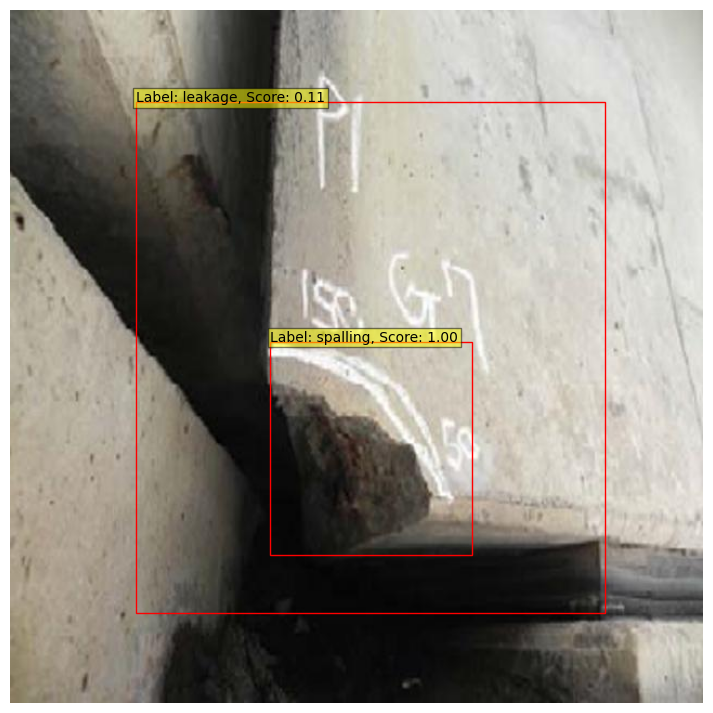

In [ ]:
import torch
from torchvision.models.detection import ssdlite320_mobilenet_v3_large
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Define the label map
LABEL_MAP = {
    1: 'corrosion',
    2: 'crack',
    3: 'freelime',
    4: 'leakage',
    5: 'spalling',
    6: 'damage'
}

# Load your SSD model
model = ssdlite320_mobilenet_v3_large(weights=None)
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/ssd_model_final.pth'
checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
# Ensure compatibility with CPU/GPU
checkpoint_state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

# Debugging: Check what keys are in the checkpoint and the model
print("Checkpoint keys:", checkpoint_state_dict.keys())
print("Model keys:", model.state_dict().keys())

# Filter and load the state dict
filtered_state_dict = {k: v for k, v in checkpoint_state_dict.items() if k in model.state_dict() and v.shape == model.state_dict()[k].shape}
model_state_dict = model.state_dict()
model_state_dict.update(filtered_state_dict)
model.load_state_dict(model_state_dict)
model.eval()

# Image transformations (for model input)
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Function to visualize predictions
def visualize_predictions(image, boxes, labels, scores, threshold=0.1):  # Lowered the threshold to 0.1
    fig, ax = plt.subplots(1, figsize=(12, 9))
    ax.imshow(image)
    for i in range(len(boxes)):
        box = boxes[i]
        label_idx = labels[i].item()
        label = LABEL_MAP.get(label_idx, 'Unknown')
        score = scores[i].item()
        if score > threshold:  # Filter boxes with score above threshold
            rect = patches.Rectangle((box[0], box[1]), box[2] - box[0], box[3] - box[1],
                                     linewidth=1, edgecolor='r', facecolor='none')
            ax.add_patch(rect)
            plt.text(box[0], box[1], f'Label: {label}, Score: {score:.2f}',
                     bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 2})
    plt.axis('off')
    plt.show()

# Load the damage image
image_path = '/content/drive/MyDrive/Colab Notebooks/train/Suginaga-spalling-0361_png.rf.496644df775cea07c642d22ca06fed05.jpg'
# Replace with your image path
image = Image.open(image_path).convert('RGB')

# Apply transformations
image_tensor = transform(image).unsqueeze(0)  # Add batch dimension

# Make predictions
with torch.no_grad():
    predictions = model(image_tensor)

# Extract boxes, labels, and scores
boxes = predictions[0]['boxes'].cpu().numpy()
labels = predictions[0]['labels'].cpu().numpy()
scores = predictions[0]['scores'].cpu().numpy()

# Debugging: Print the predictions with more detail
print("Raw Predictions:")
for i in range(len(boxes)):
    print(f"Box: {boxes[i]}, Label: {LABEL_MAP.get(labels[i].item(), 'Unknown')}, Score: {scores[i]}")

# Visualize predictions
visualize_predictions(np.array(image), boxes, labels, scores)

In [2]:
from torch.utils.data import DataLoader, Dataset
import os

class CustomDataset(Dataset):
    def __init__(self, images_dir, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.images = os.listdir(images_dir)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.images[idx])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image_path

# Directory containing test images
test_images_dir = '/content/drive/MyDrive/Colab Notebooks/test'
test_dataset = CustomDataset(test_images_dir, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)


NameError: name 'transform' is not defined